In [40]:
!pip install torcheval

In [41]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torcheval.metrics import BinaryConfusionMatrix

In [42]:
# Generate circle dataset
X, y = make_circles(n_samples=1000, noise=0.07, random_state=42, factor=0.5)

In [43]:
X = torch.tensor(X)
y = torch.tensor(y)

In [44]:
X.dtype, y.dtype

(torch.float64, torch.int64)

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [46]:
device

'cuda'

In [47]:
X=X.to(device)
y=y.to(device)

## Train_Test_Split

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
X_train = X_train.float() # randomly assifgn weight are in float, so it converted into the float
y_train = y_train.float()
X_test = X_train.float()
y_test = y_train.float()

In [51]:
def accuracy(y_true, y_pred):
    correct=torch.eq(y_true, y_pred).sum().item()
    acc=(correct/len(y_pred)) * 100
    return acc

# Creating the model

In [52]:
class Classification(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(in_features=2, out_features=5)
        self.l2=nn.Linear(in_features=5, out_features=1)
    def forward(self, X:torch.Tensor)->torch.Tensor:
        return self.l2(self.l1(X))


In [53]:
import requests
from pathlib import Path
if Path("helper_function.py").is_file():
    print("helper_function.py path already exist")
else:
    print("Downloading helper_function.py")
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_function.py", "wb") as f:
        f.write(request.content)
from helper_function import plot_predictions, plot_decision_boundary

helper_function.py path already exist


In [54]:
torch.manual_seed(42)
model1=Classification()

In [55]:
model1.state_dict()

OrderedDict([('l1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('l1.bias', tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('l2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('l2.bias', tensor([-0.2060]))])

In [56]:
next(model1.parameters()).device

device(type='cpu')

In [57]:
model1=model1.to(device)

In [58]:
model1

Classification(
  (l1): Linear(in_features=2, out_features=5, bias=True)
  (l2): Linear(in_features=5, out_features=1, bias=True)
)

In [59]:
# Loss function and optimizer
loss=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(params=model1.parameters(), lr=0.01)


In [60]:
y_logit=model1(X_train)[:5]
y_logit.T.squeeze().shape
y_train.shape

torch.Size([800])

In [61]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
X_train = X_train.float() # randomly assifgn weight are in float, so it converted into the float
y_train = y_train.float()
X_test = X_train.float()
y_test = y_train.float()
epochs=1000
for epoch in range(epochs):
    model1.train()
    y_logit_train=model1(X_train).squeeze() # the thing which come from the model is called logit
    y_pred_train=torch.round(torch.sigmoid(y_logit_train))
    train_acc=accuracy(y_train, y_pred_train)
    l=loss(y_logit_train, y_train)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    model1.eval()
    with torch.inference_mode():
        y_logit_test=model1(X_test).squeeze()
        y_pred_test=torch.round(torch.sigmoid(y_logit_test))
        test_loss=loss(y_logit_test, y_test)
        test_acc=accuracy(y_true=y_test, y_pred=y_pred_test)
    if epoch%100==0:
        print(f"Epoch: {epoch} |Loss={l}, Train_Acc={train_acc} | Test_Loss={test_loss}, Test_acc={test_acc}")



Epoch: 0 |Loss=0.6956433653831482, Train_Acc=50.0 | Test_Loss=0.6944899559020996, Test_acc=50.0
Epoch: 100 |Loss=0.6929067969322205, Train_Acc=51.625 | Test_Loss=0.6929067969322205, Test_acc=51.625
Epoch: 200 |Loss=0.6929067373275757, Train_Acc=51.625 | Test_Loss=0.6929067373275757, Test_acc=51.625
Epoch: 300 |Loss=0.6929067969322205, Train_Acc=51.625 | Test_Loss=0.6929067969322205, Test_acc=51.625
Epoch: 400 |Loss=0.6929067969322205, Train_Acc=51.625 | Test_Loss=0.6929067969322205, Test_acc=51.625
Epoch: 500 |Loss=0.6929067969322205, Train_Acc=51.625 | Test_Loss=0.6929067969322205, Test_acc=51.625
Epoch: 600 |Loss=0.6929067969322205, Train_Acc=51.625 | Test_Loss=0.6929067969322205, Test_acc=51.625
Epoch: 700 |Loss=0.6929067969322205, Train_Acc=51.625 | Test_Loss=0.6929067969322205, Test_acc=51.625
Epoch: 800 |Loss=0.6929067969322205, Train_Acc=51.625 | Test_Loss=0.6929067969322205, Test_acc=51.625
Epoch: 900 |Loss=0.6929067969322205, Train_Acc=51.625 | Test_Loss=0.6929067969322205, Te

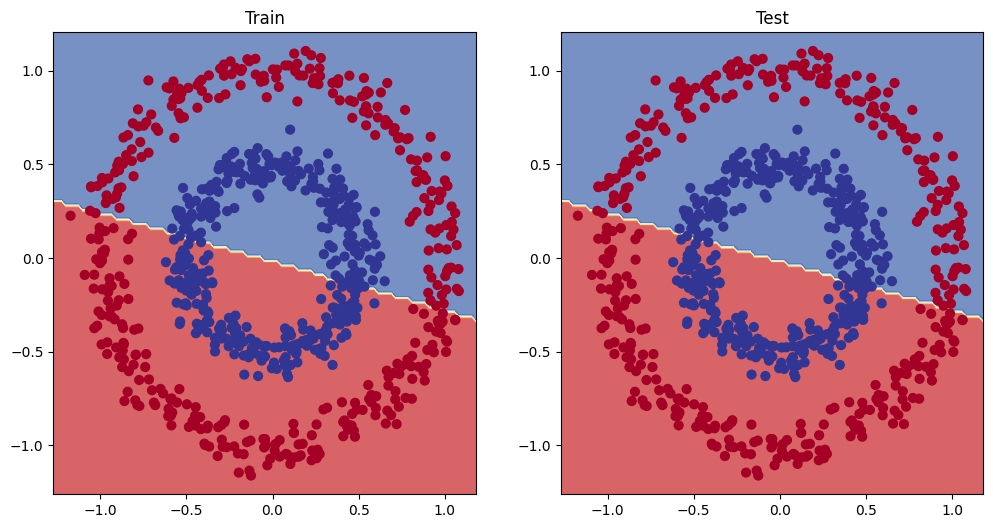

In [62]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)


In [63]:
y_pred_train=y_pred_train.to(torch.int64)
y_train=y_train.to(torch.int64)

In [64]:
import torch
from torcheval.metrics import BinaryConfusionMatrix
metric = BinaryConfusionMatrix()
metric.update(y_pred_train, y_train)
metric.compute()

tensor([[208., 192.],
        [195., 205.]])

In [65]:
import torch
from torcheval.metrics import BinaryConfusionMatrix
metric = BinaryConfusionMatrix()
metric.update(y_pred_train, y_train)
metric.compute()

tensor([[208., 192.],
        [195., 205.]])

In [66]:
import torch

# Assuming you have a tensor named 'tensor_float32' of type torch.float32
tensor_float32 = torch.tensor([1.2, 2.3, 3.4], dtype=torch.float32)

# Convert the tensor to torch.int64
tensor_int64 = tensor_float32.to(torch.int64)

print("Float32 Tensor:", tensor_float32)
print("Int64 Tensor:", tensor_int64)

Float32 Tensor: tensor([1.2000, 2.3000, 3.4000])
Int64 Tensor: tensor([1, 2, 3])


In [67]:
class CirleModelv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(in_features=2, out_features=10)
        self.l2=nn.Linear(in_features=10,out_features=10)
        self.l3=nn.Linear(in_features=10,out_features=1)
        self.r=nn.ReLU()
    def forward(self,X:torch.Tensor)-> torch.Tensor:
        x=self.l1(X)
        x=self.r(x)
        x=self.l2(x)
        x=self.r(x)
        x=self.l3(x)
        return x


In [68]:
model2 = CirleModelv1()

In [69]:
loss = torch.nn.BCEWithLogitsLoss()
optimizer=optim.Adam(params=model2.parameters(), lr=0.01)

In [70]:
model2=model2.to(device)

In [73]:
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs=1000
for epoch in range(epochs):
    model2.train()
    y_logit=model2(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logit))
    l1=loss(y_logit, y_train)
    train_acc=accuracy(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    l1.backward()
    optimizer.step()
    model2.eval()
    with torch.inference_mode():
        y_logit_test=model2(X_test).squeeze()
        y_pred_test=torch.round(torch.sigmoid(y_logit_test))
        test_loss=loss(y_logit_test, y_test)
        test_acc=accuracy(y_true=y_test, y_pred=y_pred_test)
    if epoch % 100==0:
        print(f"train acc:{train_acc}, train loss:{l1} || Test acc:{test_acc}, Test Loss: {test_loss}")



train acc:50.625, train loss:0.6903921365737915 || Test acc:49.5, Test Loss: 0.6889322996139526
train acc:100.0, train loss:0.05624007433652878 || Test acc:100.0, Test Loss: 0.05388620123267174
train acc:100.0, train loss:0.008498810231685638 || Test acc:100.0, Test Loss: 0.008416786789894104
train acc:100.0, train loss:0.003989522345364094 || Test acc:100.0, Test Loss: 0.003965307027101517
train acc:100.0, train loss:0.0023128348402678967 || Test acc:100.0, Test Loss: 0.0023020224180072546
train acc:100.0, train loss:0.0014734492870047688 || Test acc:100.0, Test Loss: 0.0014674057019874454
train acc:100.0, train loss:0.001027434947900474 || Test acc:100.0, Test Loss: 0.0010241378331556916
train acc:100.0, train loss:0.0007655398221686482 || Test acc:100.0, Test Loss: 0.0007634716457687318
train acc:100.0, train loss:0.0005851662135683 || Test acc:100.0, Test Loss: 0.00058370380429551
train acc:100.0, train loss:0.0004671992501243949 || Test acc:100.0, Test Loss: 0.00046613067388534546

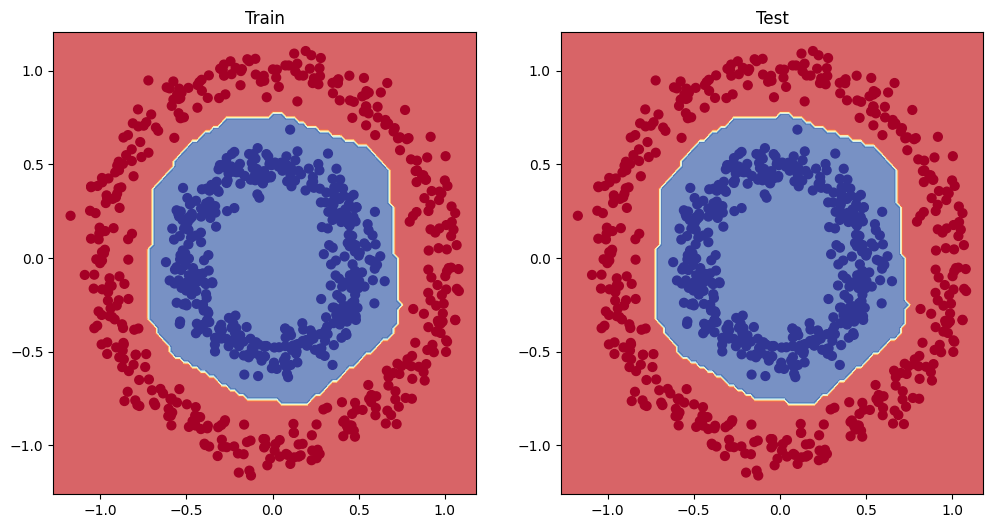

In [84]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, X_test, y_test)


In [75]:
y_pred=y_pred.to(torch.int64)
y_train=y_train.to(torch.int64)

In [76]:
import torch
from torcheval.metrics import BinaryConfusionMatrix
metric = BinaryConfusionMatrix()
metric.update(y_pred, y_train)
metric.compute()

tensor([[400.,   0.],
        [  0., 400.]])